# Метод опорных векторов на практике


Краткое описание:  нужно обучить несколько моделей и сделать важные выводы.

Наборы данных: TestData.csv и TrainData.csv.

In [122]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, FunctionTransformer
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedBaggingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [123]:
def analyze_df(df):
    rows_count, columns_count=df.shape
    print('Количество столбцов:', columns_count)
    print('Количество строк:', rows_count)

    display(df.head())

    display(df.describe())

    df.info()

    print("\nТипы данных:")
    print(df.dtypes)

    duplicate_count = df.duplicated().sum()
    print("\nКоличество дубликатов:", duplicate_count)

    print("\nКоличество пропущенных значений (по столбцам):")
    missing_values= df.isnull().sum()
    print(missing_values)

    total_missing = missing_values.sum()
    print("\nОбщее количество пропущенных значений:", total_missing)

    print('\nУникальные значения (по столбцам):')
    print(df.nunique())
     # Гистограммы для числовых признаков
    if not df.select_dtypes(include=[float, int]).empty:
        df.select_dtypes(include=[float, int]).hist(figsize=(15, 6))
        plt.suptitle('Гистограммы числовых признаков')
        plt.show()
    else:
        print("\nНет числовых данных для построения гистограмм.")

    # Матрица корреляции
    numeric_df = df.select_dtypes(include=[float, int])
    if not numeric_df.empty:
        correlation_matrix = numeric_df.corr()
        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
        plt.title('Матрица корреляции числовых признаков')
        plt.show()
    else:
        print("\nНет числовых данных для построения матрицы корреляции.")

Количество столбцов: 15
Количество строк: 7500


,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,target
0,50,218.593930,273536,0.104575,4,0.445026,0.274531,0.444334,5.970149,0.300298,0.0,0,49,0.100000,0
1,32,276.771005,173314,0.224684,11,0.445026,0.439103,0.444334,5.970149,0.300298,0.0,0,60,0.244418,0
2,38,218.593930,28887,0.032491,7,0.445026,0.274531,0.444334,25.606721,0.300298,0.0,0,50,0.244418,0
3,19,218.593930,427862,0.179322,10,0.049127,0.044987,0.009499,25.606721,0.300298,0.0,0,35,0.244418,0
4,44,218.593930,109339,0.032491,7,0.098837,0.115721,0.066581,5.970149,0.113590,0.0,0,46,0.185185,0


,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,target
count,7500.000000,7425.000000,7.500000e+03,7500.000000,7500.000000,7500.000000,5625.000000,7500.000000,7500.000000,7500.000000,7490.000000,7500.000000,7500.000000,7500.000000,7500.000000
mean,38.579600,238.905308,1.903850e+05,0.238933,10.083200,0.238934,0.240556,0.238933,23.893333,0.238933,1068.693992,88.974933,40.670800,0.238955,0.238933
std,13.647719,76.198282,1.058674e+05,0.151738,2.546071,0.190283,0.147371,0.193365,4.451530,0.087708,7430.344770,404.517032,12.330051,0.041685,0.426460
min,17.000000,64.259070,1.930200e+04,0.000029,1.000000,0.049127,0.000000,0.009499,5.970149,0.113590,0.000000,0.000000,1.000000,0.000080,0.000000
25%,28.000000,218.593930,1.180190e+05,0.171817,9.000000,0.049127,0.115721,0.066581,25.606721,0.113590,0.000000,0.000000,40.000000,0.244418,0.000000
50%,37.000000,218.593930,1.795685e+05,0.179322,10.000000,0.098837,0.241573,0.103024,25.606721,0.300298,0.000000,0.000000,40.000000,0.244418,0.000000
75%,47.000000,218.593930,2.394418e+05,0.239316,12.000000,0.445026,0.439103,0.444334,25.606721,0.300298,0.000000,0.000000,45.000000,0.244418,0.000000
max,90.000000,575.396825,1.226583e+06,0.729323,16.000000,0.445026,0.482222,0.484375,25.606721,0.300298,99999.000000,4356.000000,99.000000,0.466666,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      7500 non-null   int64  
 1   f2      7425 non-null   float64
 2   f3      7500 non-null   int64  
 3   f4      7500 non-null   float64
 4   f5      7500 non-null   int64  
 5   f6      7500 non-null   float64
 6   f7      5625 non-null   float64
 7   f8      7500 non-null   float64
 8   f9      7500 non-null   float64
 9   f10     7500 non-null   float64
 10  f11     7490 non-null   float64
 11  f12     7500 non-null   int64  
 12  f13     7500 non-null   int64  
 13  f14     7500 non-null   float64
 14  target  7500 non-null   int64  
dtypes: float64(9), int64(6)
memory usage: 879.0 KB

Типы данных:
f1          int64
f2        float64
f3          int64
f4        float64
f5          int64
f6        float64
f7        float64
f8        float64
f9        float64
f10       float64
f11       float64


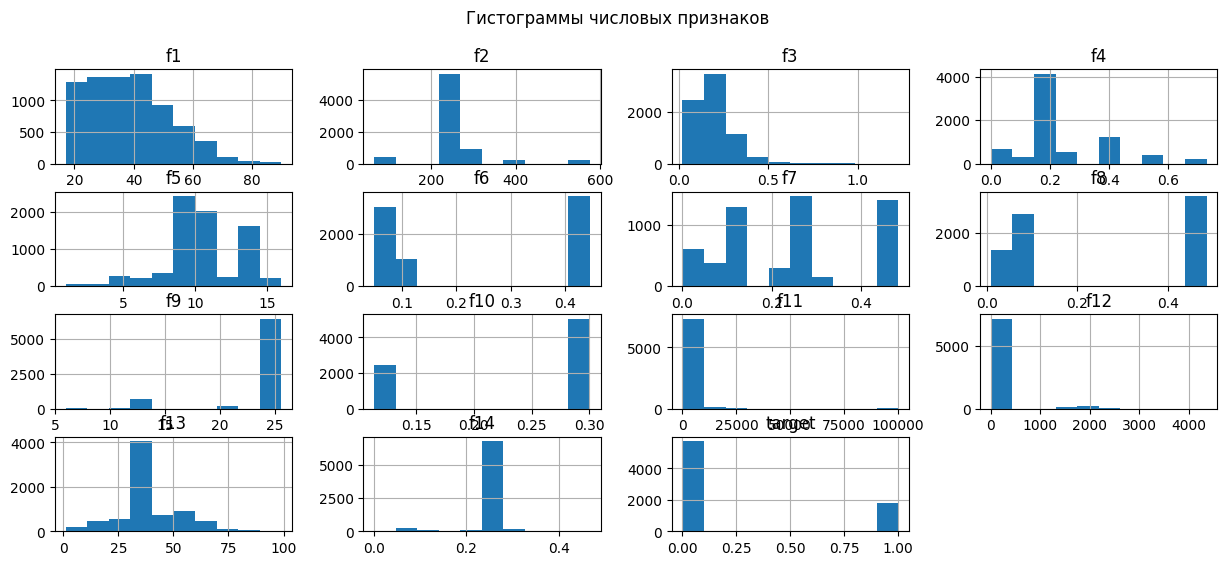

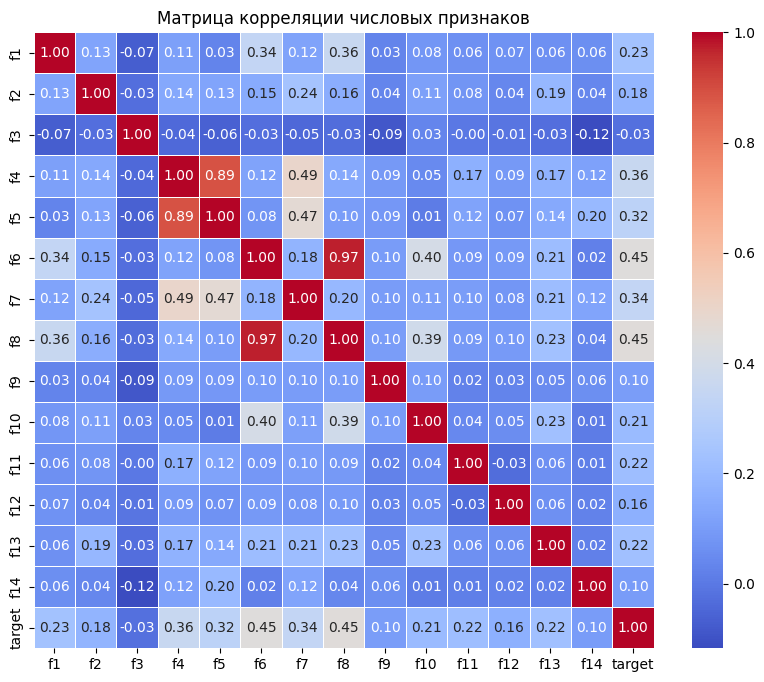

In [124]:
df_train = pd.read_csv('TrainData.csv')
analyze_df(df_train)

Количество столбцов: 15
Количество строк: 7500


,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,target
0,50,218.593930,273536,0.104575,4,0.445026,0.274531,0.444334,5.970149,0.300298,0.0,0,49,0.100000,0
1,32,276.771005,173314,0.224684,11,0.445026,0.439103,0.444334,5.970149,0.300298,0.0,0,60,0.244418,0
2,38,218.593930,28887,0.032491,7,0.445026,0.274531,0.444334,25.606721,0.300298,0.0,0,50,0.244418,0
3,19,218.593930,427862,0.179322,10,0.049127,0.044987,0.009499,25.606721,0.300298,0.0,0,35,0.244418,0
4,44,218.593930,109339,0.032491,7,0.098837,0.115721,0.066581,5.970149,0.113590,0.0,0,46,0.185185,0


,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,target
count,7500.000000,7500.000000,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000
mean,38.579600,238.702194,1.903850e+05,0.238933,10.083200,0.238934,0.240810,0.238933,23.893333,0.238933,1067.269067,88.974933,40.670800,0.238955,0.238933
std,13.647719,75.843216,1.058674e+05,0.151738,2.546071,0.190283,0.127625,0.193365,4.451530,0.087708,7425.491311,404.517032,12.330051,0.041685,0.426460
min,17.000000,64.259070,1.930200e+04,0.000029,1.000000,0.049127,0.000000,0.009499,5.970149,0.113590,0.000000,0.000000,1.000000,0.000080,0.000000
25%,28.000000,218.593930,1.180190e+05,0.171817,9.000000,0.049127,0.131370,0.066581,25.606721,0.113590,0.000000,0.000000,40.000000,0.244418,0.000000
50%,37.000000,218.593930,1.795685e+05,0.179322,10.000000,0.098837,0.241573,0.103024,25.606721,0.300298,0.000000,0.000000,40.000000,0.244418,0.000000
75%,47.000000,218.593930,2.394418e+05,0.239316,12.000000,0.445026,0.274531,0.444334,25.606721,0.300298,0.000000,0.000000,45.000000,0.244418,0.000000
max,90.000000,575.396825,1.226583e+06,0.729323,16.000000,0.445026,0.482222,0.484375,25.606721,0.300298,99999.000000,4356.000000,99.000000,0.466666,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      7500 non-null   int64  
 1   f2      7500 non-null   float64
 2   f3      7500 non-null   int64  
 3   f4      7500 non-null   float64
 4   f5      7500 non-null   int64  
 5   f6      7500 non-null   float64
 6   f7      7500 non-null   float64
 7   f8      7500 non-null   float64
 8   f9      7500 non-null   float64
 9   f10     7500 non-null   float64
 10  f11     7500 non-null   float64
 11  f12     7500 non-null   int64  
 12  f13     7500 non-null   int64  
 13  f14     7500 non-null   float64
 14  target  7500 non-null   int64  
dtypes: float64(9), int64(6)
memory usage: 879.0 KB

Типы данных:
f1          int64
f2        float64
f3          int64
f4        float64
f5          int64
f6        float64
f7        float64
f8        float64
f9        float64
f10       float64
f11       float64


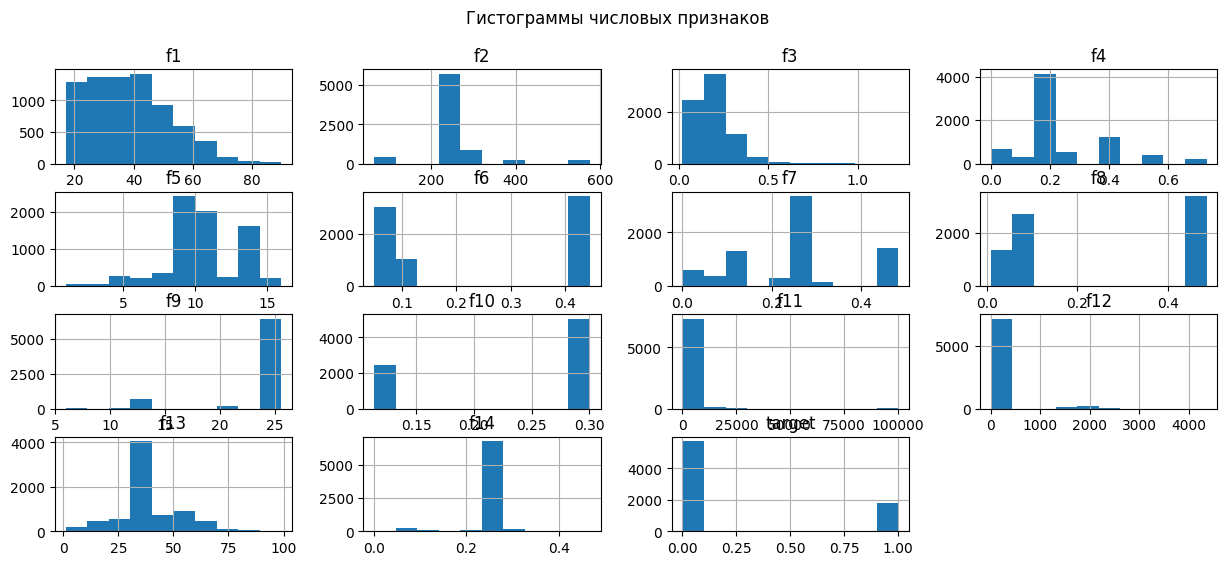

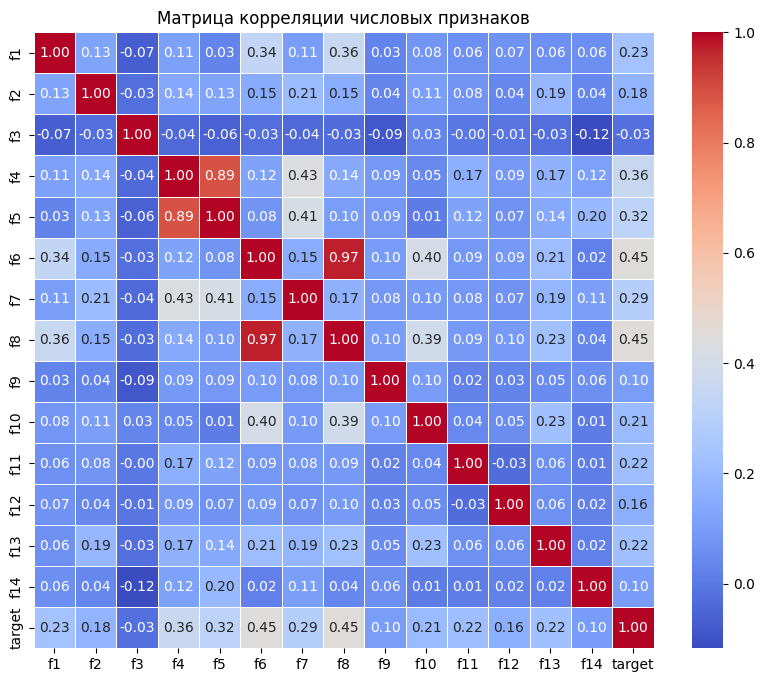

In [125]:
df_train.fillna(df_train.median(), inplace=True)
analyze_df(df_train)

Количество столбцов: 15
Количество строк: 2500


,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,target
0,31,238.933333,47296,0.238933,10,0.238933,0.238933,0.238933,23.893333,0.238933,0,1740,20,0.238933,0
1,24,238.933333,33088,0.238933,7,0.238933,0.238933,0.238933,23.893333,0.238933,0,0,40,0.238933,0
2,18,238.933333,283342,0.238933,7,0.238933,0.238933,0.238933,23.893333,0.238933,0,0,20,0.238933,0
3,19,238.933333,393712,0.238933,9,0.238933,0.238933,0.238933,23.893333,0.238933,0,0,20,0.238933,0
4,28,238.933333,200515,0.238933,10,0.238933,0.238933,0.238933,23.893333,0.238933,0,0,40,0.238933,0


,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,target
count,2500.000000,2.500000e+03,2500.000000,2.500000e+03,2500.000000,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2500.000000,2500.00000,2500.000000,2.500000e+03,2500.000000
mean,38.069200,2.389333e+02,191561.425200,2.389333e-01,10.056800,2.389333e-01,2.389333e-01,2.389333e-01,2.389333e+01,2.389333e-01,1022.667200,83.76080,40.108800,2.389333e-01,0.234800
std,13.442168,5.912898e-12,107542.508483,1.424146e-14,2.554875,1.424146e-14,1.424146e-14,1.424146e-14,9.594246e-14,1.424146e-14,6786.871929,387.72358,12.109914,1.424146e-14,0.423959
min,17.000000,2.389333e+02,19302.000000,2.389333e-01,1.000000,2.389333e-01,2.389333e-01,2.389333e-01,2.389333e+01,2.389333e-01,0.000000,0.00000,3.000000,2.389333e-01,0.000000
25%,27.000000,2.389333e+02,119098.750000,2.389333e-01,9.000000,2.389333e-01,2.389333e-01,2.389333e-01,2.389333e+01,2.389333e-01,0.000000,0.00000,38.750000,2.389333e-01,0.000000
50%,37.000000,2.389333e+02,177510.500000,2.389333e-01,10.000000,2.389333e-01,2.389333e-01,2.389333e-01,2.389333e+01,2.389333e-01,0.000000,0.00000,40.000000,2.389333e-01,0.000000
75%,47.000000,2.389333e+02,238851.250000,2.389333e-01,12.000000,2.389333e-01,2.389333e-01,2.389333e-01,2.389333e+01,2.389333e-01,0.000000,0.00000,45.000000,2.389333e-01,0.000000
max,90.000000,2.389333e+02,910398.000000,2.389333e-01,16.000000,2.389333e-01,2.389333e-01,2.389333e-01,2.389333e+01,2.389333e-01,99999.000000,2559.00000,99.000000,2.389333e-01,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      2500 non-null   int64  
 1   f2      2500 non-null   float64
 2   f3      2500 non-null   int64  
 3   f4      2500 non-null   float64
 4   f5      2500 non-null   int64  
 5   f6      2500 non-null   float64
 6   f7      2500 non-null   float64
 7   f8      2500 non-null   float64
 8   f9      2500 non-null   float64
 9   f10     2500 non-null   float64
 10  f11     2500 non-null   int64  
 11  f12     2500 non-null   int64  
 12  f13     2500 non-null   int64  
 13  f14     2500 non-null   float64
 14  target  2500 non-null   int64  
dtypes: float64(8), int64(7)
memory usage: 293.1 KB

Типы данных:
f1          int64
f2        float64
f3          int64
f4        float64
f5          int64
f6        float64
f7        float64
f8        float64
f9        float64
f10       float64
f11         int64


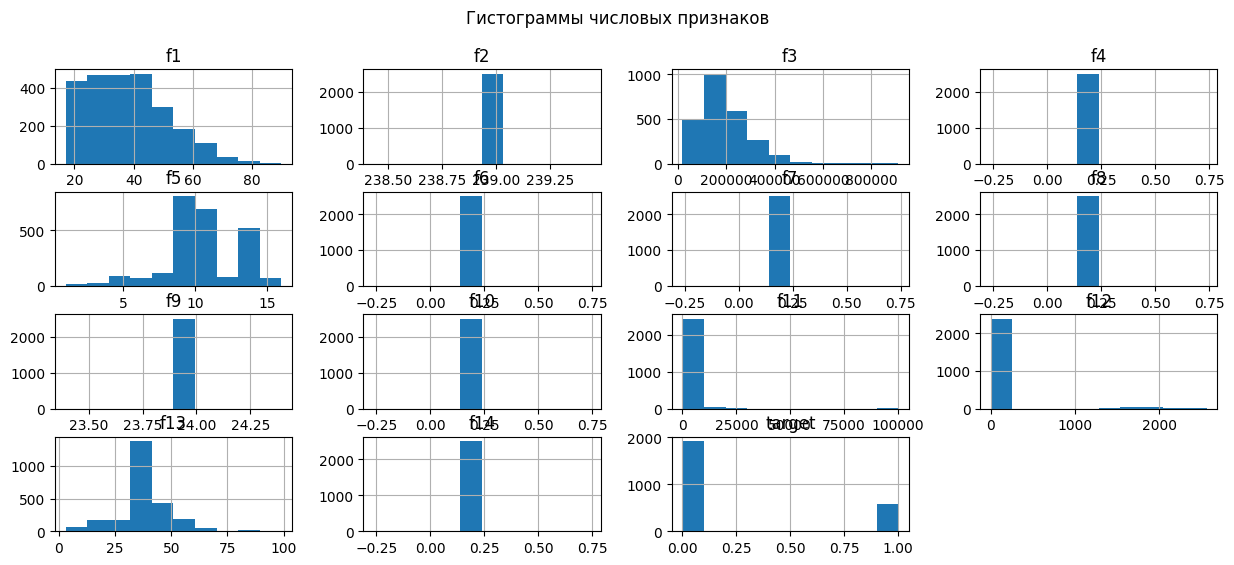

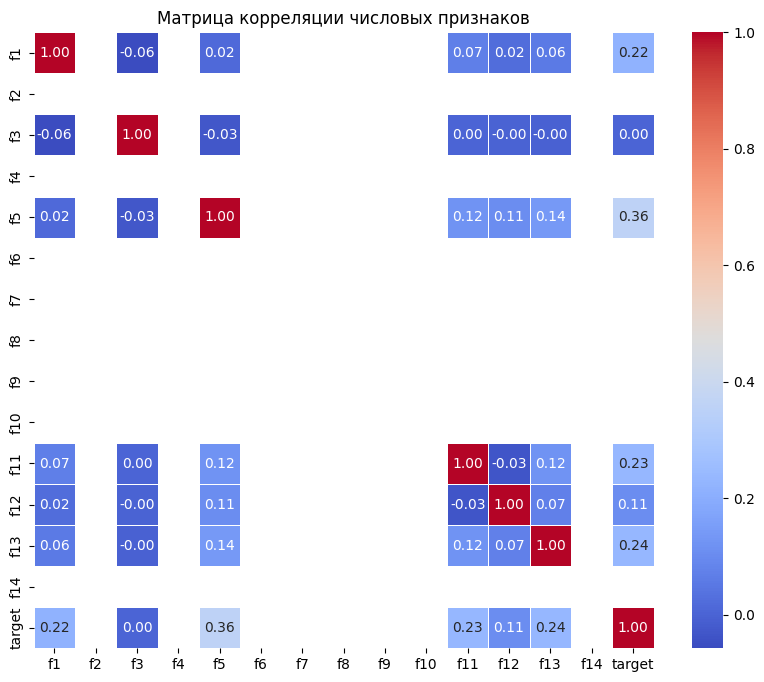

In [126]:
df_test=pd.read_csv('TestData.csv')
analyze_df(df_test)

Количество столбцов: 15
Количество строк: 2500


,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,target
0,31,238.933333,47296,0.238933,10,0.238933,0.238933,0.238933,23.893333,0.238933,0,1740,20,0.238933,0
1,24,238.933333,33088,0.238933,7,0.238933,0.238933,0.238933,23.893333,0.238933,0,0,40,0.238933,0
2,18,238.933333,283342,0.238933,7,0.238933,0.238933,0.238933,23.893333,0.238933,0,0,20,0.238933,0
3,19,238.933333,393712,0.238933,9,0.238933,0.238933,0.238933,23.893333,0.238933,0,0,20,0.238933,0
4,28,238.933333,200515,0.238933,10,0.238933,0.238933,0.238933,23.893333,0.238933,0,0,40,0.238933,0


,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,target
count,2500.000000,2.500000e+03,2500.000000,2.500000e+03,2500.000000,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2500.000000,2500.00000,2500.000000,2.500000e+03,2500.000000
mean,38.069200,2.389333e+02,191561.425200,2.389333e-01,10.056800,2.389333e-01,2.389333e-01,2.389333e-01,2.389333e+01,2.389333e-01,1022.667200,83.76080,40.108800,2.389333e-01,0.234800
std,13.442168,5.912898e-12,107542.508483,1.424146e-14,2.554875,1.424146e-14,1.424146e-14,1.424146e-14,9.594246e-14,1.424146e-14,6786.871929,387.72358,12.109914,1.424146e-14,0.423959
min,17.000000,2.389333e+02,19302.000000,2.389333e-01,1.000000,2.389333e-01,2.389333e-01,2.389333e-01,2.389333e+01,2.389333e-01,0.000000,0.00000,3.000000,2.389333e-01,0.000000
25%,27.000000,2.389333e+02,119098.750000,2.389333e-01,9.000000,2.389333e-01,2.389333e-01,2.389333e-01,2.389333e+01,2.389333e-01,0.000000,0.00000,38.750000,2.389333e-01,0.000000
50%,37.000000,2.389333e+02,177510.500000,2.389333e-01,10.000000,2.389333e-01,2.389333e-01,2.389333e-01,2.389333e+01,2.389333e-01,0.000000,0.00000,40.000000,2.389333e-01,0.000000
75%,47.000000,2.389333e+02,238851.250000,2.389333e-01,12.000000,2.389333e-01,2.389333e-01,2.389333e-01,2.389333e+01,2.389333e-01,0.000000,0.00000,45.000000,2.389333e-01,0.000000
max,90.000000,2.389333e+02,910398.000000,2.389333e-01,16.000000,2.389333e-01,2.389333e-01,2.389333e-01,2.389333e+01,2.389333e-01,99999.000000,2559.00000,99.000000,2.389333e-01,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      2500 non-null   int64  
 1   f2      2500 non-null   float64
 2   f3      2500 non-null   int64  
 3   f4      2500 non-null   float64
 4   f5      2500 non-null   int64  
 5   f6      2500 non-null   float64
 6   f7      2500 non-null   float64
 7   f8      2500 non-null   float64
 8   f9      2500 non-null   float64
 9   f10     2500 non-null   float64
 10  f11     2500 non-null   int64  
 11  f12     2500 non-null   int64  
 12  f13     2500 non-null   int64  
 13  f14     2500 non-null   float64
 14  target  2500 non-null   int64  
dtypes: float64(8), int64(7)
memory usage: 293.1 KB

Типы данных:
f1          int64
f2        float64
f3          int64
f4        float64
f5          int64
f6        float64
f7        float64
f8        float64
f9        float64
f10       float64
f11         int64


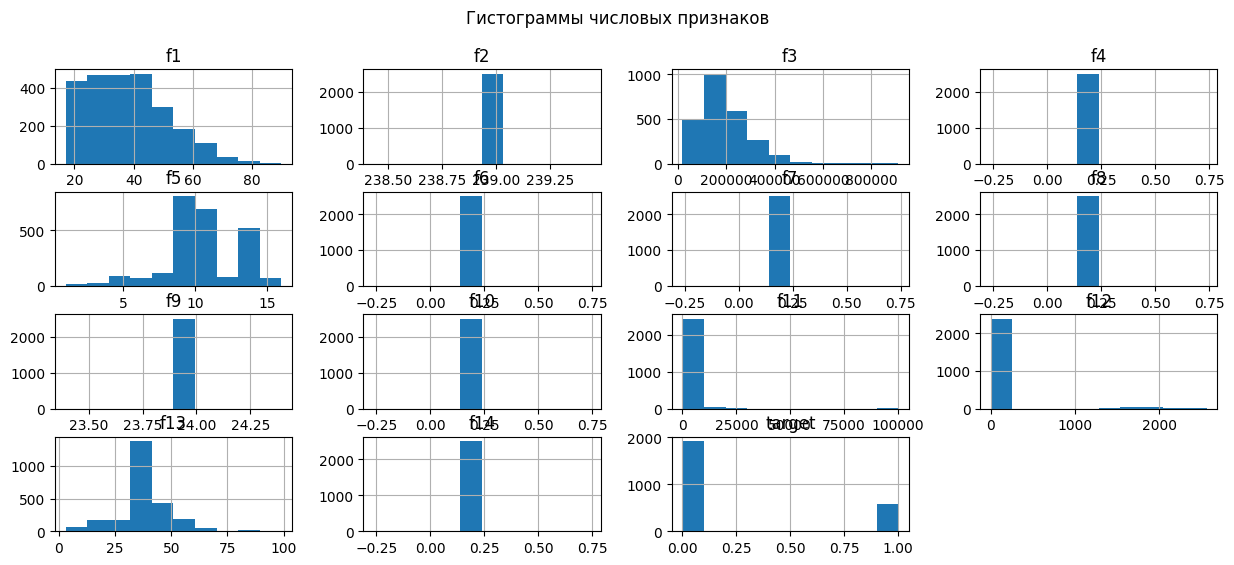

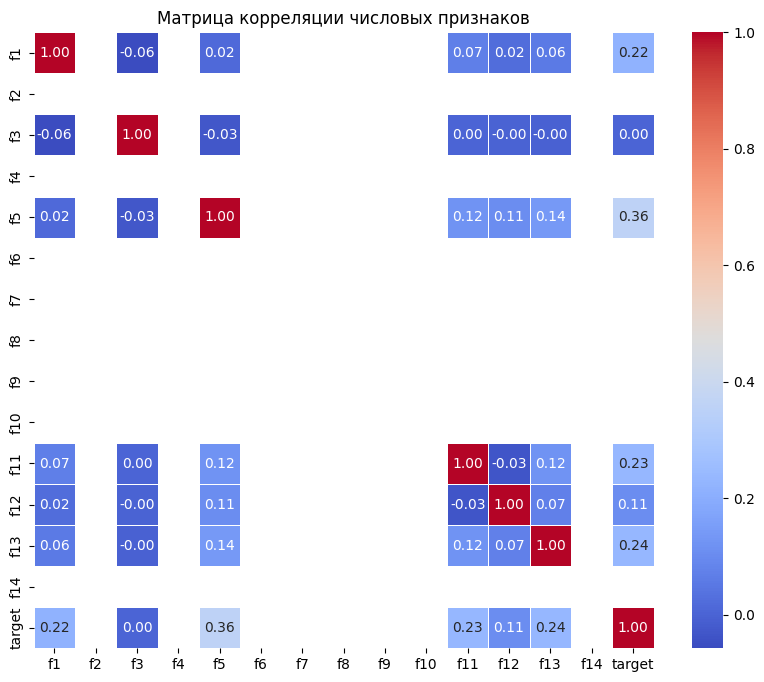

In [127]:
df_test.fillna(df_test.median(), inplace=True)
analyze_df(df_test)

In [128]:
df_train['target'].value_counts(normalize=True)

,proportion
target,
0,0.761067
1,0.238933


In [129]:
df_test['target'].value_counts(normalize=True)

,proportion
target,
0,0.7652
1,0.2348


## Вывод:
Распределение в двух датафреймах составляет 76 на 24 %, что свидетельствует о дисбалансе классов. Такая метрика как accuracy покажет примерный результат от 90-100% на любой модели. В связи с этим для работы с  дисбалансными классами лучше использовать следующие метрики: ROC-AUC, AUR-PR, F1-мера. Так же для работы с дисбалансными классами очень хорошо себя покажут модели с возможностью изменять веса в классах, либо если это не предполагает задание, то можно использовать дублирование меньшего класса для того что бы повысить его значимость для модели, но при таком варианте есть проблема переобучение модели, так как дублированный класс не будет нести прогнозную способность.
В нашем варианте мы остановимся на а f1- мере.

## 3. Построим baseline-модели:
1.
разобьём TrainData на тренировочные (Train) и тестовые данные (Test)
;2.
обучим LogisticRegression и SVC с параметрами по умолчанию на тренировочных данных (Train
)3. ;
примените модели на тестовых данных (Test).

In [130]:
def transform_data():
    scaler=StandardScaler()

    y_train = df_train['target']
    x_train=df_train.drop('target', axis=1)
    x_train=scaler.fit_transform(x_train)

    y_test = df_test['target']
    x_test=df_test.drop('target', axis=1)
    x_test=scaler.transform(x_test)

    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = transform_data()

In [131]:
def calculate_model (model = SVC(kernel='rbf', class_weight='balanced'), title ='Модель SVC с ядром rdf и сбаллансированными классами'):
  print(title, '\n')
  model.fit(x_train, y_train)
  y_pred = model.predict(x_test)
  print(classification_report(y_test, y_pred))
  print('f1_score: ',f1_score(y_test, y_pred))
  return y_pred


### 4. Улучшите модели
Попробуем улучшить качество обученных моделей:

### 5. Оценим на отложенной выборке качество наилучшей модели

Возьмём ту, которая дала наилучшее качество на тестовых данных (Test). Применим её на отложенной выборке (TestData) и выведите на экран значение метрики f1.

# Модель с опорными векторами

In [132]:
calculate_model()

Модель SVC с ядром rdf и сбаллансированными классами 

              precision    recall  f1-score   support

           0       0.83      0.92      0.88      1913
           1       0.61      0.39      0.48       587

    accuracy                           0.80      2500
   macro avg       0.72      0.66      0.68      2500
weighted avg       0.78      0.80      0.78      2500

f1_score:  0.47875647668393784


array([0, 0, 0, ..., 0, 1, 1])

In [133]:
calculate_model(SVC(kernel='poly', degree=3), 'Модель SVC с ядром poly третьей степени и с сбаллансированными классами')

Модель SVC с ядром poly третьей степени и с сбаллансированными классами 

              precision    recall  f1-score   support

           0       0.78      1.00      0.87      1913
           1       0.97      0.06      0.12       587

    accuracy                           0.78      2500
   macro avg       0.88      0.53      0.50      2500
weighted avg       0.82      0.78      0.70      2500

f1_score:  0.12140575079872204


array([0, 0, 0, ..., 0, 0, 0])

In [134]:
calculate_model(SVC(kernel='sigmoid'), 'Модель SVC с ядром sigmoid и с сбаллансированными классами')

Модель SVC с ядром sigmoid и с сбаллансированными классами 

              precision    recall  f1-score   support

           0       0.80      0.95      0.87      1913
           1       0.61      0.25      0.35       587

    accuracy                           0.79      2500
   macro avg       0.71      0.60      0.61      2500
weighted avg       0.76      0.79      0.75      2500

f1_score:  0.35236938031591736


array([1, 0, 0, ..., 0, 1, 0])

In [135]:
calculate_model(SVC(kernel='linear'), 'Модель SVC с ядром precomputed и с сбаллансированными классами')

Модель SVC с ядром precomputed и с сбаллансированными классами 

              precision    recall  f1-score   support

           0       0.81      1.00      0.89      1913
           1       0.94      0.22      0.36       587

    accuracy                           0.81      2500
   macro avg       0.87      0.61      0.63      2500
weighted avg       0.84      0.81      0.77      2500

f1_score:  0.3603851444291609


array([0, 0, 0, ..., 0, 1, 0])

In [136]:
# Добавляем полиномиальные признаки
def polinomial_transform_data():
  x_train, x_test, y_train, y_test = transform_data()
  poly = PolynomialFeatures(degree=2, include_bias=False)
  x_train = poly.fit_transform(x_train)
  x_test = poly.transform(x_test)
  return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = polinomial_transform_data()
calculate_model(title='Модель SVC с дополнительными полиноминальными признаками и с сбаллансированными классами')

Модель SVC с дополнительными полиноминальными признаками и с сбаллансированными классами 

              precision    recall  f1-score   support

           0       0.81      0.99      0.89      1913
           1       0.88      0.25      0.39       587

    accuracy                           0.82      2500
   macro avg       0.85      0.62      0.64      2500
weighted avg       0.83      0.82      0.77      2500

f1_score:  0.38992042440318303


array([0, 0, 0, ..., 0, 1, 0])

In [137]:
# Добавлем гармонические признаки
def harmonic_transform_data():
  x_train, x_test, y_train, y_test = transform_data()
  harmonic = FunctionTransformer(np.sin)
  x_train = harmonic.fit_transform(x_train)
  x_test = harmonic.transform(x_test)
  return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = harmonic_transform_data()
y_pred1=calculate_model(title='Модель SVC с дополнительными гармоническими признаками и с сбаллансированными классами')

Модель SVC с дополнительными гармоническими признаками и с сбаллансированными классами 

              precision    recall  f1-score   support

           0       0.88      0.79      0.83      1913
           1       0.49      0.66      0.56       587

    accuracy                           0.76      2500
   macro avg       0.69      0.72      0.70      2500
weighted avg       0.79      0.76      0.77      2500

f1_score:  0.5616338439095551


# Модель с логистической регрессией

In [138]:
x_train, x_test, y_train, y_test = transform_data()
calculate_model(LogisticRegression(class_weight='balanced'), 'Логистическая регрессия с балансировкой классов')

Логистическая регрессия с балансировкой классов 

              precision    recall  f1-score   support

           0       0.84      0.94      0.89      1913
           1       0.67      0.41      0.51       587

    accuracy                           0.81      2500
   macro avg       0.76      0.67      0.70      2500
weighted avg       0.80      0.81      0.80      2500

f1_score:  0.5063829787234042


array([0, 0, 0, ..., 1, 1, 0])

In [139]:
calculate_model(LogisticRegression(class_weight='balanced', penalty='elasticnet', solver='saga', l1_ratio=0.2), 'Логистическая регрессия с регуляризацией L1L2 с балансировкой классов')

Логистическая регрессия с регуляризацией L1L2 с балансировкой классов 

              precision    recall  f1-score   support

           0       0.84      0.94      0.89      1913
           1       0.68      0.41      0.51       587

    accuracy                           0.82      2500
   macro avg       0.76      0.68      0.70      2500
weighted avg       0.80      0.82      0.80      2500

f1_score:  0.5137420718816068


array([0, 0, 0, ..., 1, 1, 0])

In [140]:
calculate_model(LogisticRegression(class_weight='balanced', C=0.1), 'Логистическая регрессия с C=0.1 с балансировкой классов')

Логистическая регрессия с C=0.1 с балансировкой классов 

              precision    recall  f1-score   support

           0       0.84      0.94      0.89      1913
           1       0.68      0.41      0.51       587

    accuracy                           0.81      2500
   macro avg       0.76      0.67      0.70      2500
weighted avg       0.80      0.81      0.80      2500

f1_score:  0.5079702444208289


array([0, 0, 0, ..., 1, 1, 0])

In [141]:
calculate_model(LogisticRegression(class_weight='balanced', penalty='l1', solver='liblinear'), 'Логистическая регрессия с L1 с балансировкой классов')

Логистическая регрессия с L1 с балансировкой классов 

              precision    recall  f1-score   support

           0       0.84      0.94      0.89      1913
           1       0.68      0.41      0.51       587

    accuracy                           0.82      2500
   macro avg       0.76      0.68      0.70      2500
weighted avg       0.80      0.82      0.80      2500

f1_score:  0.5121693121693122


array([0, 0, 0, ..., 1, 1, 0])

In [142]:
# Добавляем полиномиальные признаки
x_train, x_test, y_train, y_test = polinomial_transform_data()
calculate_model(LogisticRegression(class_weight='balanced', max_iter=200), title='Логистическая регрессия  с дополнительными полиноминальными признаками и с балансировкой классов')

Логистическая регрессия  с дополнительными полиноминальными признаками и с балансировкой классов 

              precision    recall  f1-score   support

           0       0.90      0.71      0.80      1913
           1       0.44      0.74      0.55       587

    accuracy                           0.72      2500
   macro avg       0.67      0.73      0.67      2500
weighted avg       0.79      0.72      0.74      2500

f1_score:  0.554354736172918


array([0, 0, 0, ..., 1, 1, 1])

In [143]:
# Добавлем гармонические признаки
x_train, x_test, y_train, y_test = harmonic_transform_data()
y_pred2=calculate_model(LogisticRegression(class_weight='balanced', max_iter=200), title='Логистическая регрессия  с дополнительными гармоническими признаками и с балансировкой классов')

Логистическая регрессия  с дополнительными гармоническими признаками и с балансировкой классов 

              precision    recall  f1-score   support

           0       0.87      0.91      0.89      1913
           1       0.65      0.54      0.59       587

    accuracy                           0.82      2500
   macro avg       0.76      0.73      0.74      2500
weighted avg       0.81      0.82      0.82      2500

f1_score:  0.5901942645698427



## Выводы
Добавление дополнительных гармонических признаков значительно улучшело метрику F1. Для логистической регресси метрика стала F1=0.59 а для метода опрных векторов F1=0.56. В исходных данных вероятно много шума и гармонические признаки лучше всего описывают шум.

6. Выполним хитрый трюк

Часто смешивание различных моделей даёт улучшение итогового предсказания. Попробуем смешать две лучшие модели по формуле:
predfinal=α⋅pred1+(1−α)⋅pred2
.

Значение α подберём в цикле по Test-выборке. Оценим качество на отложенной выборке.


Лучшая alpha: 0.00
Максимальный f1_score: 0.5902

              precision    recall  f1-score   support

           0       0.87      0.91      0.89      1913
           1       0.65      0.54      0.59       587

    accuracy                           0.82      2500
   macro avg       0.76      0.73      0.74      2500
weighted avg       0.81      0.82      0.82      2500



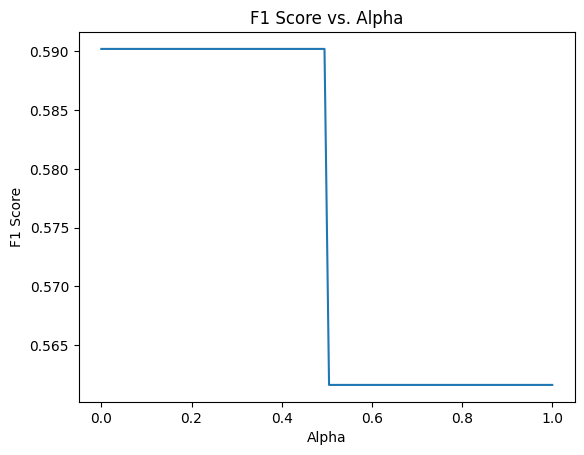

In [144]:
f1_scores=[]
alphas=np.linspace(0, 1, 100)
best_alpha=0
best_f1=0
best_classification_report = None

for alpha in alphas:
  predfinal=y_pred1*alpha+y_pred2*(1-alpha)
  predfinal=(predfinal>=0.5).astype(int)
  f1=f1_score(y_test, predfinal)
  f1_scores.append(f1)
  if f1>best_f1:
    best_f1=f1
    best_alpha=alpha
    best_classification_report = classification_report(y_test, predfinal)

print(f'Лучшая alpha: {best_alpha:.2f}')
print(f'Максимальный f1_score: {best_f1:.4f}\n')
print(best_classification_report)

plt.plot(alphas, f1_scores)
plt.xlabel('Alpha')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Alpha')
plt.show()


## Общие выводы



Для улучшения качестваданных изначальных данных я применил масштабирование признаков и балансировку. Данные, вероятно содержат много шума поэтому были добавлены дополнительные гармонические признаки для улучшения предсказаний моделей.

Для улучшения качества модели с опорными векторами я изменял ядро. Наилйчшим оказалась радиальное ядро (по умолчанию).  

Для улучшения качества модели с логистической регрессией я изменял регуляризацию и штраф С. Наилйчшим оказалась L1L2 регулиризация.

Какие подходы вы использовали для улучшения работы baseline-моделей?

При добавлении дополнительных гармонических признаков значительно улучилась метрика F1. Для логистической регресси метрика стала F1=0.59 а для метода опрных векторов F1=0.56.

Логистическая регрессия почему-то спарилась лучше чем метод опорных векторов. И при смешанной модели метод опрных векторов только мешает и его для представленных данных лучше не применть. Поэтому лучшая alpha=0 получилась при применении только логистической регрессии.

В целом модель получилась с низким F1=0.59 и недообучилась.